In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.utils.show_install import show_install
from fastai.callbacks import SaveModelCallback

In [3]:
bs = 64

In [4]:
show_install()



```text
=== Software === 
python        : 3.7.1
fastai        : 1.0.46
fastprogress  : 0.1.19
torch         : 1.0.0
nvidia driver : 410.72
torch cuda    : 10.0.130 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 7611MB | Tesla P4

=== Environment === 
platform      : Linux-4.9.0-8-amd64-x86_64-with-debian-9.7
distro        : #1 SMP Debian 4.9.130-2 (2018-10-27)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter/MURA
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload

/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/jupyter/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
O

## Load the Data

First, we need to load the data from the directories into fastai databunch.

In [5]:
data_root = Path("./MURA-v1.1/")

In [6]:
data_root.ls()

[PosixPath('MURA-v1.1/Untitled.ipynb'),
 PosixPath('MURA-v1.1/train_labeled_studies.csv'),
 PosixPath('MURA-v1.1/valid'),
 PosixPath('MURA-v1.1/valid_image_paths.csv'),
 PosixPath('MURA-v1.1/train'),
 PosixPath('MURA-v1.1/train_image_paths.csv'),
 PosixPath('MURA-v1.1/.ipynb_checkpoints'),
 PosixPath('MURA-v1.1/valid_labeled_studies.csv')]

The csv file provided in the dataset folder is intended for a fast import of the dataset into the user's deep learning framework.

In [7]:
train_csv = data_root/"train_image_paths.csv"
valid_csv = data_root/"valid_image_paths.csv"

In [8]:
pd.read_csv(train_csv).head()

,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


Since the csv file uses for the image file a relative path starting with `MURA-v1.1`, it would be best to put the Jupyter Notebook right in the same directory as `MURA-v1.1` for easier path reference.

We also noticed that there is no header in the csv file. So to avoid omitting the first file, we need to use the `header=None` option.

In [9]:
column_names = ['FilePath']

In [10]:
train_df = pd.read_csv(train_csv, header=None, names=column_names)
train_df.head()

,FilePath
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [11]:
valid_df = pd.read_csv(valid_csv, header=None, names=column_names)
valid_df.head()

,FilePath
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


### Train/Valid Split

We will now proceed to examine how the dataset splits its data between train and valid sets.

The MURA paper published by the Stanford research group who kindly created this dataset states that " We split the dataset into training (11,184 patients, 13,457 studies, 36,808 images), validation (783 patients, 1,199 studies, 3,197 images), and test (206 patients, 207 studies, 556 images) sets."

In [12]:
len(train_df)

36808

In [13]:
len(valid_df)

3197

Which is indeed what we got.

In [14]:
train_df.head()

,FilePath
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [15]:
valid_df.head()

,FilePath
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


However, what concerns me is that the training and validation sets do not seem to be split randomly; rather, judging from the file names along, they seem to be split chronologically, where the first 11184 patients are in the training set while the next 783 patients fall into the validation set. This is only true, of course, if the nubmer code in the patient folder path indeed indicates a chronological order. Unfortunately, since no more details are mentioned in the paper about the data split, it cannot be guaranteed, either.

I will leave myself a note here to experiment with randomizing the distribution of patients among the train/valid set later.

### Load data from dataframe into ItemLists & Some Data Explorations

In [147]:
train_list = ImageList.from_df(train_df, path=Path("."))

In [19]:
valid_list = ImageList.from_df(valid_df, path=Path("."))

In [20]:
item_lists = ItemLists(Path("."), train_list, valid_list)
item_lists

ItemLists;

Train: ImageList (36808 items)
Image (3, 512, 380),Image (3, 512, 303),Image (3, 410, 512),Image (3, 413, 512),Image (3, 512, 440)
Path: .;

Valid: ImageList (3197 items)
Image (3, 512, 268),Image (3, 512, 268),Image (3, 499, 512),Image (3, 512, 261),Image (3, 512, 230)
Path: .;

Test: None

### Label each item and create LabelLists

Under the current API of fastai, it is easier to label the items by using regular expressions on the file names rather than using the provided csv files.

In [21]:
item_lists.train.items

array(['./MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png',
       './MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png',
       './MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png',
       './MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png', ...,
       './MURA-v1.1/train/XR_HAND/patient11183/study1_negative/image3.png',
       './MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image1.png',
       './MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image2.png',
       './MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image3.png'], dtype='<U71')

In [22]:
sample_item = item_lists.train.items[0]
sample_item

'./MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'

In [23]:
pat = re.compile("study._(positive|negative)")

In [24]:
res = pat.search(sample_item)

In [25]:
res.group(1)

'positive'

We tested the regular expression we came up with and tested it on all items. It seems to work.

In [26]:
label_func = lambda item: pat.search(item).group(1)

In [27]:
train_labels = [label_func(item) for item in item_lists.train.items]

In [28]:
len(train_labels) == len(item_lists.train.items)

True

In [29]:
set(train_labels)

{'negative', 'positive'}

In [30]:
valid_labels = [label_func(item) for item in item_lists.valid.items]

In [31]:
len(valid_labels) == len(item_lists.valid.items)

True

In [32]:
set(valid_labels)

{'negative', 'positive'}

Now we are going to use the label function we came up with on the ItemList to generate a LabelLists.

In [33]:
label_lists= item_lists.label_from_func(label_func)
label_lists

LabelLists;

Train: LabelList (36808 items)
x: ImageList
Image (3, 512, 380),Image (3, 512, 303),Image (3, 410, 512),Image (3, 413, 512),Image (3, 512, 440)
y: CategoryList
positive,positive,positive,positive,positive
Path: .;

Valid: LabelList (3197 items)
x: ImageList
Image (3, 512, 268),Image (3, 512, 268),Image (3, 499, 512),Image (3, 512, 261),Image (3, 512, 230)
y: CategoryList
positive,positive,positive,positive,positive
Path: .;

Test: None

In [34]:
label_lists.classes

['negative', 'positive']

### Some Data Explorations

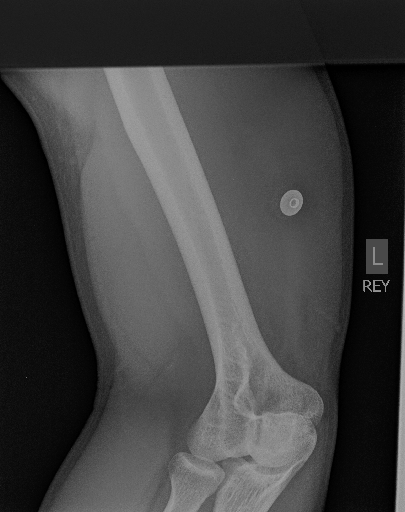

In [197]:
random_sample = np.random.randint(0, len(train_list))
sample_img = train_list[random_sample]
sample_img

In [198]:
sample_img.size

torch.Size([512, 405])

Since CNN requires all the inputs to be of the same sizes, we need to check if the images are of the same size.

In [199]:
[img.size for img in train_list[:10]]

[torch.Size([512, 380]),
 torch.Size([512, 303]),
 torch.Size([410, 512]),
 torch.Size([413, 512]),
 torch.Size([512, 440]),
 torch.Size([512, 413]),
 torch.Size([512, 476]),
 torch.Size([512, 501]),
 torch.Size([491, 512]),
 torch.Size([512, 343])]

Sadly, the images are not of uniform sizes. The good thing is, however, that all of their longer sides have a length of 512. That means we can easily turn them all into 512x512 by padding.

It would be instructive to explore the images with most elongated shapes.

In [200]:
ratios = []
for path in train_list.items:
    img_size = PIL.Image.open(path).size
    ratio = img_size[0]/img_size[1]
    ratios.append(ratio)
ratios = np.array(ratios)

In [214]:
widest_index = np.argmax(ratios)

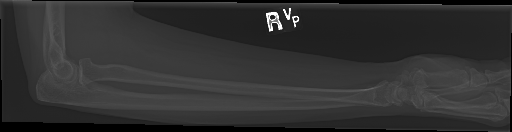

In [215]:
train_list[widest_index]

In [217]:
tallest_index= np.argmin(ratios)

It is probably the forearm. Yeah, we should not expect it to be square.

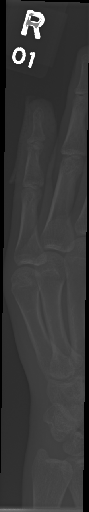

In [218]:
train_list[tallest_index]

This is a rather wierd one. It is the hand but somehow there is only part of it.

In [219]:
label_lists.train.y[tallest_index].obj

'positive'

In [231]:
foo = Path(label_lists.train.x.items[tallest_index])

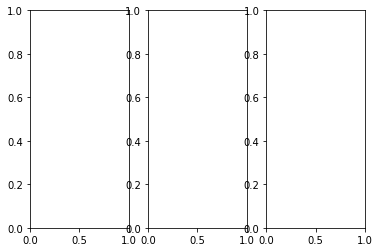

In [262]:
fig, axes = plt.subplots(ncols = 3)

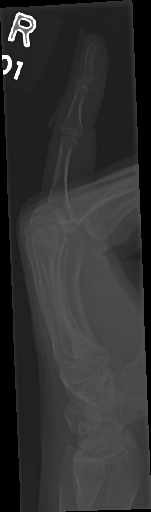

In [256]:
PIL.Image.open(foo.parents[0].ls()[0])

### Choose appropriate image transforms and create DataBunch

We will start with just the default transforms.

In [35]:
tfms = get_transforms()

In [36]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0

In [99]:
doc(label_lists.transform)

transform [source] transform ( tfms : Optional [ Tuple [ Union [ Callable , Collection [ Callable ]], Union [ Callable , Collection [ Callable ]]]]= (None, None) , ** kwargs ) 
 
 Set tfms to be applied to the xs of the train and validation set. 
 Show in docs

In [114]:
data = (label_lists.transform(None, size=512, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

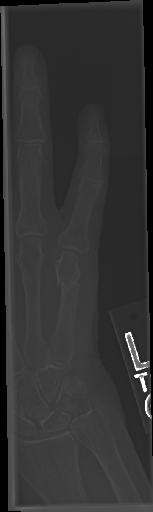

In [115]:
train_list[10000]

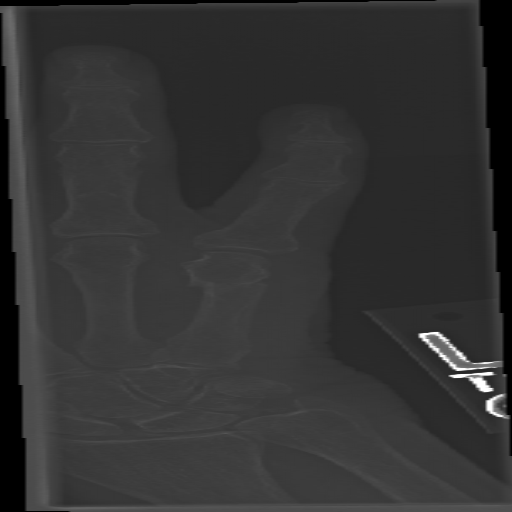

In [116]:
data.train_ds[10000][0]

In [ ]:
train_list[5000]

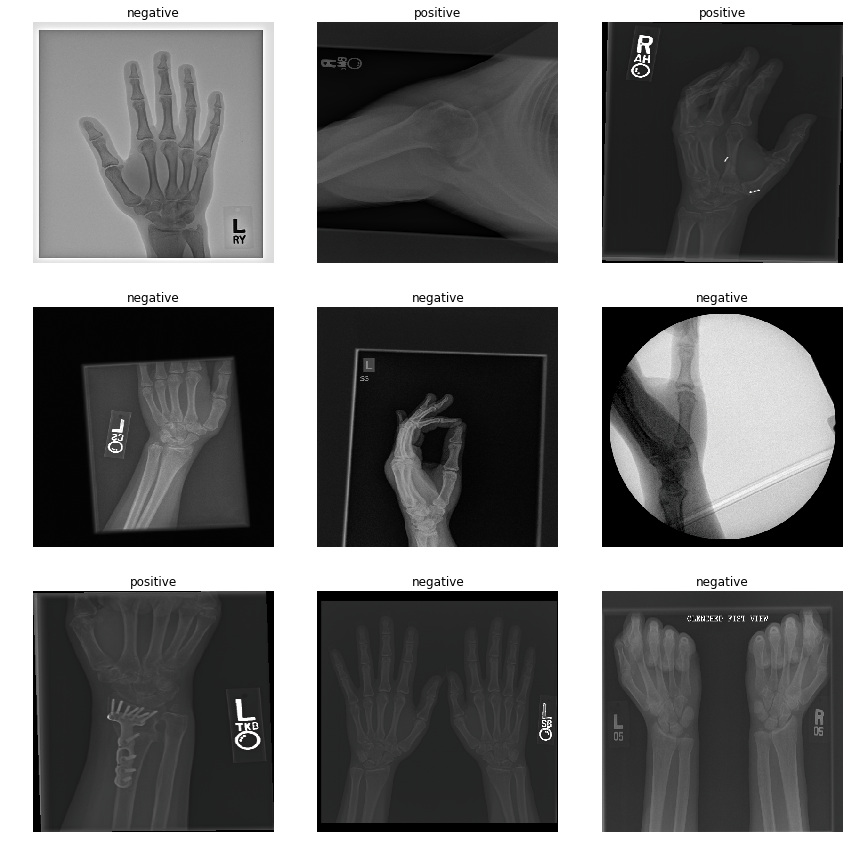

In [118]:
data.show_batch(3)

I am not a radiologist so I cannot really judge whether these X-Rays look normal after the transformations, but at least they don't look too ridiculous to a layman. So we will pass for now.

## Train ResNet-50

In [112]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


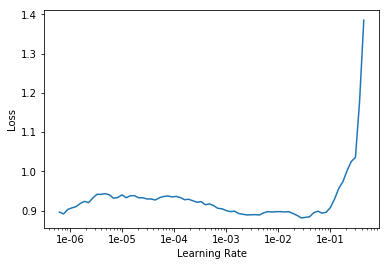

In [113]:
learn.lr_find()
learn.recorder.plot()

In [193]:
freeze_best = '20190305-rn50-comboloss-alldata-128-best'

In [194]:
learn.fit_one_cycle(4, max_lr=slice(0.01),
                    callbacks=[
                        SaveModelCallback(learn,
                                                 monitor='accuracy',
                                                 mode='max',
                                                 name=freeze_best)
                    ])

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


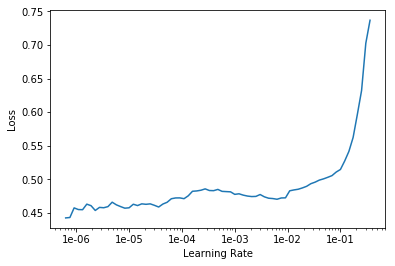

In [167]:
learn.lr_find()
learn.recorder.plot()

In [170]:
learn.fit_one_cycle(4, max_lr=slice(0.003), 
                    callbacks=[
                        SaveModelCallback(learn,
                                                 monitor='accuracy',
                                                 mode='max',
                                                 name=freeze_best)
                    ]
                   )

epoch,train_loss,valid_loss,accuracy,time
1,0.463974,0.476967,0.789490,02:03
2,0.463015,0.465292,0.790741,02:04
3,0.456626,0.451293,0.795746,02:04
4,0.452312,0.465029,0.790116,02:05


Better model found at epoch 1 with accuracy value: 0.7894901633262634.
Better model found at epoch 2 with accuracy value: 0.7907413244247437.
Better model found at epoch 3 with accuracy value: 0.7957460284233093.


In [177]:
kappa = KappaScore()

In [180]:
learn.metrics = [accuracy, kappa]

In [181]:
learn.fit_one_cycle(1, max_lr=slice(0.003), 
                    callbacks=[
                        SaveModelCallback(learn,
                                                 monitor='accuracy',
                                                 mode='max',
                                                 name=freeze_best)
                    ]
                   )

epoch,train_loss,valid_loss,accuracy,kappa_score,time
1,0.458473,0.455228,0.798248,0.591863,02:04


Better model found at epoch 1 with accuracy value: 0.7982483506202698.


In [183]:
interp = learn.interpret()

In [119]:
interp.plot_confusion_matrix()

NameError: name 'interp' is not defined